In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import h3
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from src.settings import *
from shapely.geometry import Polygon
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from src.tools.osmnx_utils import get_place_dir_name
from src.tools.h3_utils import get_resolution_buffered_suffix
from pathlib import Path
import plotly.express as px
from src.tools.clustering import cluster_hdbscan
from src.models.tfidf import tfidf
from src.tools.dim_reduction import reduce_umap
import matplotlib.pyplot as plt
import contextily as ctx
from keplergl import KeplerGl
from src.tools.aggregation import aggregate_hex
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from pytorch_lightning.loggers import WandbLogger
import wandb
from src.models.autoencoder import LitAutoEncoder
import random

tqdm.pandas()

In [3]:
SEED = 42

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# def seed_worker(worker_id):
#     worker_seed = torch.initial_seed() % 2**32
#     np.random.seed(worker_seed)
#     random.seed(worker_seed)

In [4]:
cities = pd.read_csv(RAW_DATA_DIR.joinpath("cities.csv"))
cities = cities[cities["country"] == "Poland"]
cities: pd.DataFrame = cities[cities["city"] != "Świdnica"].reset_index(drop=True)
cities

,city,country
0,Wrocław,Poland
1,Warszawa,Poland
2,Kraków,Poland
3,Poznań,Poland
4,Gdańsk,Poland
5,Szczecin,Poland
6,Katowice,Poland
7,Częstochowa,Poland
8,Białystok,Poland


In [5]:
resolution = 9
buffered = True
network_type = "drive"

pbar = tqdm(cities.itertuples(), total=cities.shape[0])
edges_hex_cities = []
hexagons_cities = []
for row in pbar:
    place_name = f"{row.city},{row.country}"
    place_dir_name = get_place_dir_name(place_name)
    pbar.set_description(place_name)

    hexagon_city = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"hex_{get_resolution_buffered_suffix(resolution, buffered)}.geojson"), driver="GeoJSON")
    hexagon_city["city"] = row.city
    hexagons_cities.append(hexagon_city)

    edges_hex_city = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"edges_{network_type}_{get_resolution_buffered_suffix(resolution, buffered)}.geojson"), driver="GeoJSON")
    edges_hex_city["city"] = row.city
    edges_hex_cities.append(edges_hex_city)

hexagons = pd.concat(hexagons_cities, ignore_index=True).set_index("h3_id")
edges_hex = pd.concat(edges_hex_cities, ignore_index=True)
hex_agg = aggregate_hex(edges_hex.drop(columns="city"))
hex_agg_tfidf = tfidf(hex_agg)

del edges_hex_cities
del hexagons_cities

Białystok,Poland: 100%|██████████| 9/9 [01:29<00:00,  9.95s/it]


In [7]:
edges_hex.to_pickle(PROCESSED_DATA_DIR.joinpath("road_features.pkl.gz"))

In [6]:
X = torch.Tensor(hex_agg.values)
X_tfidf = torch.Tensor(hex_agg_tfidf.values)

batch_size = 200
num_workers = 5

X_dl = DataLoader(X, batch_size=batch_size, num_workers=num_workers)
X_tfidf_dl = DataLoader(X_tfidf, batch_size=batch_size, num_workers=num_workers)

n = X.shape[1]

In [7]:
wandb_logger = WandbLogger()
run = wandb.init(project="osm-autoencoder", reinit=True)

model = LitAutoEncoder(in_dim=n, hidden_dim=64, code_dim=30)
trainer = pl.Trainer(gpus=1, max_epochs=40, logger=wandb_logger)
trainer.fit(model, X_tfidf_dl)

y = model(X)
y_df = pd.DataFrame(y.detach().numpy()).add_prefix("x_")
y_df.index = hex_agg.index

run.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: calychas (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 10.4 K
1 | decoder | Sequential | 10.5 K
---------------------------------------
20.9 K    Trainable params
0         Non-trainable params
20.9 K    Total params
0.084     Total estimated model params size (MB)


Epoch 39: 100%|██████████| 81/81 [00:03<00:00, 22.14it/s, loss=0.126, v_num=5min]


train_loss_step,0.04643
epoch,39
trainer/global_step,3239
_runtime,177
_timestamp,1621359155
_step,103
train_loss_epoch,0.14879


train_loss_step,█▂▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [8]:
# from sklearn.preprocessing import normalize
# y_df = pd.DataFrame(normalize(y_df, norm="l2"), columns=y_df.columns, index=y_df.index)  # cosine metric
# y_df["cluster"] = cluster_hdbscan(y_df, min_cluster_size=50, metric="euclidean")[0]
# hexagons_clustered = hexagons.join(y_df).dropna()

In [19]:
from sklearn.cluster import AgglomerativeClustering

agglomerative_clustering = AgglomerativeClustering(n_clusters=20, affinity="euclidean", linkage="ward")
y_df["cluster"] = pd.Series(agglomerative_clustering.fit_predict(y_df), index=y_df.index).astype("category")
hexagons_clustered = hexagons.join(y_df).dropna()

<AxesSubplot:>

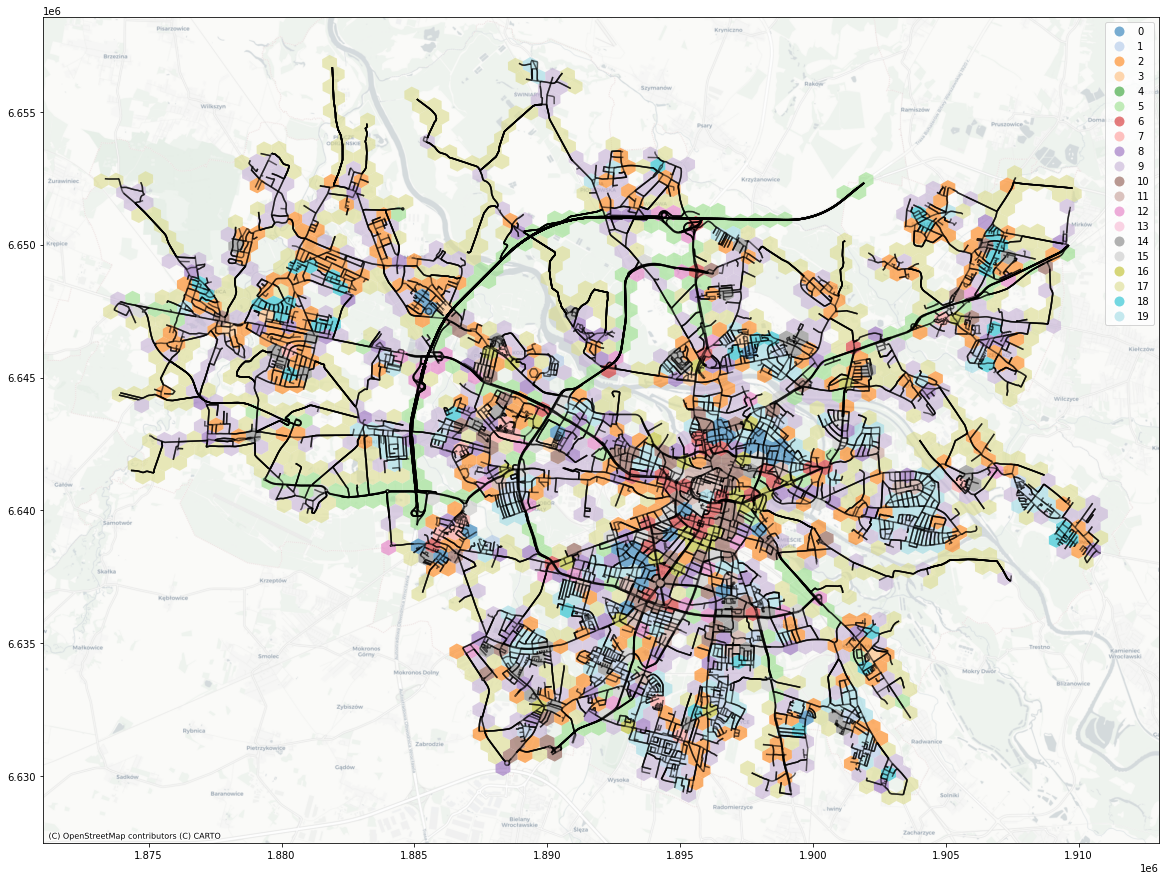

In [20]:
from src.tools.vis_utils import plot_hexagons_map

city = "Wrocław"
plot_hexagons_map(hexagons_clustered[hexagons_clustered["city"] == city], edges_hex[edges_hex["city"] == city], "cluster")

In [21]:
# from scipy.cluster.hierarchy import dendrogram, linkage
# from matplotlib import pyplot as plt

# linked = linkage(y_df.drop(columns="cluster").values, method="ward")

# # labelList = range(1, 11)

# plt.figure(figsize=(10, 7))
# dendrogram(linked)
#             # orientation='top',
#             # # labels=labelList,
#             # distance_sort='descending',
#             # show_leaf_counts=True)
# plt.show()

In [22]:
y_df

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,cluster
h3_id,,,,,,,,,,,,,,,,,,,,,
891e05901b3ffff,-0.147423,0.324401,-0.272509,-0.501775,-0.195316,-0.540840,0.014604,-0.188135,-0.034065,0.420092,...,-0.259665,-0.281277,-0.264207,0.336241,-0.215263,-0.247919,-0.012853,-0.165946,-0.034145,17
891e05901b7ffff,-0.346546,0.612161,-0.566424,-0.790106,-0.402225,-0.746361,-0.166129,-0.332428,-0.183026,0.531855,...,-0.270777,-0.551982,-0.346566,0.747577,-0.337576,-0.273248,0.108979,-0.322631,-0.074206,9
891e0590527ffff,-0.744793,1.187680,-1.154252,-1.366768,-0.816042,-1.157402,-0.527594,-0.621012,-0.480949,0.755382,...,-0.293001,-1.093392,-0.511283,1.570250,-0.582202,-0.323905,0.352641,-0.636002,-0.154327,9
891e059052fffff,-0.147423,0.324401,-0.272509,-0.501775,-0.195316,-0.540840,0.014604,-0.188135,-0.034065,0.420092,...,-0.259665,-0.281277,-0.264207,0.336241,-0.215263,-0.247919,-0.012853,-0.165946,-0.034145,17
891e0590537ffff,-1.356699,2.207561,-4.589529,-4.666032,-6.369331,-8.087285,0.288927,-3.206888,-2.936691,0.620185,...,1.476932,-3.742114,-3.149361,4.304876,-4.130321,-0.823953,4.838062,-3.881491,1.161972,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891f724dec3ffff,0.265580,0.017193,-0.179161,-0.646706,0.257965,-0.913032,0.422216,0.089278,0.108957,0.804046,...,-0.537007,-0.356452,-0.043233,-0.064980,-0.278634,-0.309247,-0.235608,0.069818,-0.291689,17
891f724dec7ffff,0.265580,0.017193,-0.179161,-0.646706,0.257965,-0.913032,0.422216,0.089278,0.108957,0.804046,...,-0.537007,-0.356452,-0.043233,-0.064980,-0.278634,-0.309247,-0.235608,0.069818,-0.291689,17
891f724decfffff,0.265580,0.017193,-0.179161,-0.646706,0.257965,-0.913032,0.422216,0.089278,0.108957,0.804046,...,-0.537007,-0.356452,-0.043233,-0.064980,-0.278634,-0.309247,-0.235608,0.069818,-0.291689,17


In [23]:
from src.tools.vis_utils import plot_clusters
embedding = reduce_umap(hex_agg_tfidf, n_components=2, n_neighbors=30, metric="euclidean")[0]
embedding["cluster"] = y_df["cluster"]
plot_clusters(embedding)

In [24]:
hex_tfidf_by_cluster = hex_agg_tfidf.join(y_df).groupby(by="cluster")

In [25]:
hex_tfidf_by_cluster_mean = hex_tfidf_by_cluster.mean().reset_index()
hex_tfidf_by_cluster_mean

,cluster,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,...,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29
0,0,24.055033,4.185218,2.191693,18.208607,1.512136,0.993465,0.031899,0.048592,0.000000,...,-3.167303,-0.144857,-6.797479,-1.230585,9.880807,-5.063487,-0.910446,-2.277585,-3.626632,-0.423317
1,1,20.839642,5.305281,0.832625,2.736134,1.006036,0.343790,0.018030,0.000000,0.000000,...,-0.381052,-0.720587,-5.514958,-1.903481,8.364074,-3.402084,-4.956525,-0.125783,-7.221638,0.278199
2,2,8.399081,1.462788,0.460933,2.136507,0.555700,0.262930,0.033361,0.000000,0.000000,...,-0.965960,-0.865580,-1.909020,-1.052940,2.369316,-1.594865,-0.786828,-0.287335,-1.337181,-0.803008
3,3,18.668875,9.692928,2.407672,5.265961,2.621127,1.046607,0.122733,0.015580,0.000000,...,-2.467360,-0.175488,-3.434880,-3.111839,7.891856,-3.589881,-1.240615,0.075401,-4.259939,-0.201948
4,4,0.284523,0.846710,9.012387,15.185663,5.674211,2.075453,0.324047,0.000000,0.000000,...,1.118642,-3.471582,-0.822248,-3.349122,6.490417,-0.501821,-2.656567,-3.824754,-3.878269,4.714042
5,5,1.843504,6.542978,1.360755,3.822290,3.903738,1.947378,0.491966,0.033201,0.012696,...,-1.059230,-0.030588,0.454047,-1.218934,2.861880,-1.270863,-0.309231,-1.095630,-0.412163,0.655415
6,6,8.978227,47.184064,17.982660,22.680282,13.892088,5.677157,1.146366,0.181900,0.000000,...,-3.104543,0.773693,0.896992,-6.166007,12.586398,-5.781099,-4.838413,-9.795548,-4.592094,3.442344
7,7,25.878051,11.143897,3.983736,6.938134,2.154520,1.029461,0.066110,0.000000,0.000000,...,-6.609548,-0.541373,-2.135525,-7.914616,1.680654,-8.924274,-2.309735,-0.420497,-1.384481,-2.733517
8,8,9.657221,6.949631,2.059983,4.899797,1.832026,0.994649,0.190264,0.007246,0.000000,...,-1.138430,-0.772253,-2.026048,-1.692050,3.916584,-2.059373,-1.398811,-1.370075,-2.389435,-0.424152
9,9,3.512584,0.372150,0.212913,0.990212,0.189911,0.084809,0.014390,0.005978,0.000000,...,-0.359383,-0.475984,-0.841696,-0.574526,1.170077,-0.637117,-0.444096,-0.108299,-0.689704,-0.184406


In [26]:
from src.tools.feature_extraction import FEATURESET
for feature_name in FEATURESET.keys():
    fig = px.bar(hex_tfidf_by_cluster_mean, x="cluster", y=list(filter(lambda x: feature_name in x, hex_tfidf_by_cluster_mean.columns)), width=1300, title=feature_name)
    fig.update_layout(
        xaxis = dict(
            tickmode = 'linear',
        )
    )
    fig.show()

In [27]:
y_df

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,cluster
h3_id,,,,,,,,,,,,,,,,,,,,,
891e05901b3ffff,-0.147423,0.324401,-0.272509,-0.501775,-0.195316,-0.540840,0.014604,-0.188135,-0.034065,0.420092,...,-0.259665,-0.281277,-0.264207,0.336241,-0.215263,-0.247919,-0.012853,-0.165946,-0.034145,17
891e05901b7ffff,-0.346546,0.612161,-0.566424,-0.790106,-0.402225,-0.746361,-0.166129,-0.332428,-0.183026,0.531855,...,-0.270777,-0.551982,-0.346566,0.747577,-0.337576,-0.273248,0.108979,-0.322631,-0.074206,9
891e0590527ffff,-0.744793,1.187680,-1.154252,-1.366768,-0.816042,-1.157402,-0.527594,-0.621012,-0.480949,0.755382,...,-0.293001,-1.093392,-0.511283,1.570250,-0.582202,-0.323905,0.352641,-0.636002,-0.154327,9
891e059052fffff,-0.147423,0.324401,-0.272509,-0.501775,-0.195316,-0.540840,0.014604,-0.188135,-0.034065,0.420092,...,-0.259665,-0.281277,-0.264207,0.336241,-0.215263,-0.247919,-0.012853,-0.165946,-0.034145,17
891e0590537ffff,-1.356699,2.207561,-4.589529,-4.666032,-6.369331,-8.087285,0.288927,-3.206888,-2.936691,0.620185,...,1.476932,-3.742114,-3.149361,4.304876,-4.130321,-0.823953,4.838062,-3.881491,1.161972,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891f724dec3ffff,0.265580,0.017193,-0.179161,-0.646706,0.257965,-0.913032,0.422216,0.089278,0.108957,0.804046,...,-0.537007,-0.356452,-0.043233,-0.064980,-0.278634,-0.309247,-0.235608,0.069818,-0.291689,17
891f724dec7ffff,0.265580,0.017193,-0.179161,-0.646706,0.257965,-0.913032,0.422216,0.089278,0.108957,0.804046,...,-0.537007,-0.356452,-0.043233,-0.064980,-0.278634,-0.309247,-0.235608,0.069818,-0.291689,17
891f724decfffff,0.265580,0.017193,-0.179161,-0.646706,0.257965,-0.913032,0.422216,0.089278,0.108957,0.804046,...,-0.537007,-0.356452,-0.043233,-0.064980,-0.278634,-0.309247,-0.235608,0.069818,-0.291689,17


In [39]:
embedding_to_save_df = gpd.GeoDataFrame(y_df.join(hexagons[["parent", "geometry", "city", "resolution"]]).rename(columns={"parent": "h3_parent_id"}))
embedding_to_save_df.to_pickle(PROCESSED_DATA_DIR.joinpath("road_embedding.pkl.gz"))

In [40]:
hexagons.to_pickle(PROCESSED_DATA_DIR.joinpath("hexagons.pkl.gz"))

In [37]:
embedding_to_save_df

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_25,x_26,x_27,x_28,x_29,cluster,h3_parent_id,geometry,city,resolution
h3_id,,,,,,,,,,,,,,,,,,,,,
891e2047227ffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,881e204723fffff,"POLYGON ((17.09719 51.11886, 17.09722 51.11718...",Wrocław,9
891e2041867ffff,-5.378747,0.771603,-5.749843,1.119685,0.665263,-11.331374,3.179559,-1.485957,-0.268744,2.034375,...,0.396109,-2.198904,-5.934234,-2.379401,-0.910382,10,881e204187fffff,"POLYGON ((16.96557 51.05686, 16.96561 51.05518...",Wrocław,9
891e20404dbffff,-0.191601,0.169056,-0.106877,-0.186770,-0.165082,-1.016273,0.643773,0.267196,0.045801,-0.072752,...,-0.418359,-0.180219,-0.422031,-0.133116,-0.515161,17,881e20404dfffff,"POLYGON ((16.90358 51.13577, 16.90362 51.13409...",Wrocław,9
891e2040c33ffff,-0.582006,1.272617,-3.804693,-1.456747,-1.619986,-4.069328,2.944317,-0.548824,0.143232,3.027559,...,-1.670312,-1.567980,-3.621682,-0.908762,-0.483289,8,881e2040c3fffff,"POLYGON ((17.01939 51.11909, 17.01942 51.11741...",Wrocław,9
891e20423d7ffff,-0.336837,1.199190,-0.641221,-0.668527,-0.484690,-1.996236,0.930828,-0.143680,-0.103833,-0.120156,...,-0.831711,-0.230537,-0.427219,-0.588992,-0.546942,9,881e20423dfffff,"POLYGON ((16.92820 51.15671, 16.92824 51.15503...",Wrocław,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891f5104d97ffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,881f5104d9fffff,"POLYGON ((23.10581 53.10713, 23.10569 53.10549...",Białystok,9
891f5106913ffff,2.644778,2.481965,-10.605491,-8.179556,-5.400757,-10.453819,8.328604,1.574989,4.924528,1.637846,...,-10.225742,-1.871821,1.051573,0.324489,-6.181804,7,881f510691fffff,"POLYGON ((23.10508 53.13414, 23.10497 53.13251...",Białystok,9
891f51a992fffff,-1.089414,0.460215,-1.909310,-2.270251,0.244078,-2.293188,1.017712,-0.971802,0.928282,0.669215,...,-1.860974,-0.581521,-0.273016,-1.039297,-0.171614,9,881f51a993fffff,"POLYGON ((23.19803 53.15916, 23.19791 53.15752...",Białystok,9


In [53]:
zeros = torch.zeros((1, X.shape[1]))
model(zeros).detach().numpy().squeeze()

array([ 0.0555021 ,  0.04344444,  0.00668686, -0.19877295,  0.00940313,
       -0.349162  ,  0.1700421 , -0.02272386,  0.11920231,  0.3097641 ,
       -0.13769932,  0.25137907,  0.03780234,  0.22747263, -0.31611007,
       -0.15458846,  0.08668634,  0.08182073, -0.05827295,  0.18888496,
       -0.02332959, -0.24750751, -0.00365096, -0.2012625 , -0.05933614,
       -0.10311864, -0.23276374, -0.12063856, -0.01470058,  0.00615425],
      dtype=float32)